In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#Find the releative path of Lib folder
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import PyBEM2D as BEMpy

### Analytical solution

In [2]:
import numpy as np
def NeumannBC_func(Pts):
    #https://www.chegg.com/homework-help/questions-and-answers/2-solve-2d-steady-state-heat-conduction-equation-0-square-region-0-sx-s-1-0-sy-conditions--q24440992
    x,y=Pts[0],Pts[1]
    return 60*np.cos(4*np.pi*x)
def ExactSol(Pts):
    x,y=Pts[0],Pts[1]
    
    P=15*np.cos(4*np.pi*x)*np.sinh(4*np.pi*y)/(np.pi*np.cosh(4*np.pi))
    U=15*np.sin(4*np.pi*x)*np.sinh(4*np.pi*y)/(np.pi*np.cosh(4*np.pi))*4*np.pi
    V=-15*np.cos(4*np.pi*x)*np.cosh(4*np.pi*y)/(np.pi*np.cosh(4*np.pi))*4*np.pi
    
    return P,U,V

## BEM solution

[Mesh] Genetrated...
[Mesh] Discontinous Element used
[Mesh] Number of boundary elements:128(Total) 128(Edge) 0(Trace)
[Mesh] Number of Nodes:384(Total) 384(Edge) 0(Trace) 0(Source)
[Boundary Condition] BCs set up
[Boundary Condition] Dirichlet BC @ [(2, 0.0)]
[Boundary Condition] BCs set up
[Boundary Condition] Neumann BC @ [(0, <function NeumannBC_func at 0x000001D696A25F28>)]


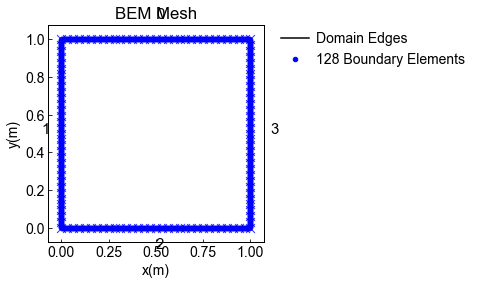

In [3]:
BEM_Case1=BEMpy.BEM2D()

#1.Build Mesh-#Anti-clock wise for internal domain
Boundary_vert=[(1.0,1.0),(0.0,1.0),(0.0, 0.0), (1.0, 0.0)]  #bottom
element_esize=1/32

BEM_Case1.set_Mesh(Boundary_vert,[],[],element_esize,[],Type="Quad")

#2.Set Boundary condition
bc0=[(2,0.0)]
BEM_Case1.set_BoundaryCondition(DirichletBC=bc0)#,RobinBC=bc1)
bc_func=[(0,NeumannBC_func)]
BEM_Case1.set_BoundaryCondition(NeumannBC=bc_func,mode='func',update=1)#,RobinBC=bc1)

#3.Set Domain Properties - permeability tensor
k11=1
k12=0
k22=1
k_tensor=[k11,k12,k22]
BEM_Case1.SetProps(k_tensor)

#Check Mesh
BEM_Case1.plot_Mesh()
#Check Node,BC if necessary
#BEM_Case1.Mesh.print_debug()

[Solution] #DOFs= 384
[Visulization] Plotting Solution


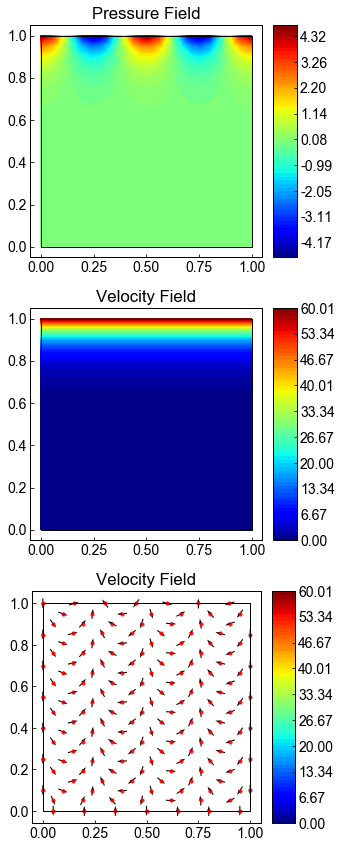

In [4]:
puv=BEM_Case1.Solve()
xx=BEM_Case1.PostProcess.plot_Solution()
#BEM_Case1.PostProcess.print_Solution()

In [5]:
#Create regular grid pts
NX=40
tol=0.0125
xi, yi = np.linspace(0+tol, 1-tol, NX), np.linspace(0+tol, 1-tol, NX)
X, Y = np.meshgrid(xi,yi)  # generates a mesh grid
Pts = np.array([(x, y)for x, y in zip(X.flatten(), Y.flatten())]) # Convert to 1D array

print("Compute L2 error for %d pts"%(len(Pts)))

#Compute L2 norm for these points
P_error=0
U_error=0
for pts in Pts:
    PUV=BEM_Case1.get_Solution(pts)
    PUV_exact=ExactSol(pts)
    
    P_error+=(PUV[0]-PUV_exact[0])*(PUV[0]-PUV_exact[0])
    U_error+=(PUV[1]-PUV_exact[1])*(PUV[1]-PUV_exact[1]) + (PUV[2]-PUV_exact[2])*(PUV[2]-PUV_exact[2])

P_error=np.sqrt(P_error/len(Pts))
U_error=np.sqrt(U_error/len(Pts))

print("%d Eles L2 P error=%s"%(BEM_Case1.Mesh.Ne,P_error))
print("%d Eles L2 U error=%s"%(BEM_Case1.Mesh.Ne,U_error))

Compute L2 error for 1600 pts
128 Eles L2 P error=1.9005191612097928e-05
128 Eles L2 U error=0.00031714753886991743


[Visulization] Plotting Solution


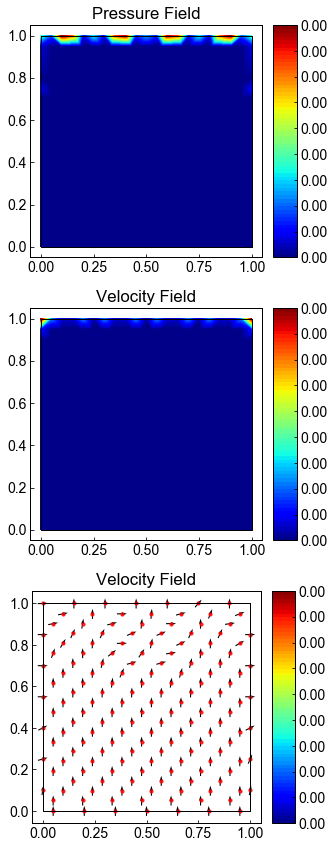

In [76]:
xx=BEM_Case1.PostProcess.plot_Solution(exact_sol=ExactSol)

In [148]:
def compute_order(Err,h):
    order=[]
    for i in range(1,len(h)):
        order.append(np.log(Err[i]/Err[i-1])/np.log(h[i]/h[i-1]))
    print("Convergence order=",np.average(order))

#BEM convergence order
h_BEM=np.array([1/4,1/8,1/16,1/32,1/64])
P2_Err_BEM=[0.056336068975866474, 0.0024591989718262142, 0.000201714071163832, 1.900519161196901e-05,1.7364626315322404e-06]
U2_Err_BEM=[1.8340893147990134,0.13471982649818671,0.009335498331152426,0.0003171475388690193,1.79600776415204e-05]

P1_Err_BEM=[0.1512518737109296,0.02843028201169771,0.006825461460470984,0.0016972777241431529,0.0004271706196240454 ]
U1_Err_BEM=[2.9525632259057275,1.1466546097576271,0.28961681018549346,0.047479006156120745,0.0073371695276209055]

P0_Err_BEM=[0.6679534659122119,0.1622460710428969,0.05843915539976279,0.0189736209647183,0.006046420666632368]
U0_Err_BEM=[11.870556232428706,5.189355890333694,2.4014237302979224,0.6692767486284847,0.07813777544091088]

#FEM convergence order
#Extremely Coarse,Coarser
h_FEM=np.array([0.327212587671806,0.12564,0.0668364308793573,0.0368881354,0.0099913541])
P2_Err_FEM=[4.209627885381093E-2,2.561454809725255E-4,8.372509892318040E-6,2.326176825418834E-7,4.396752741943261E-11]
P2_Err_FEM=np.sqrt(P2_Err_FEM)
print(P2_Err_FEM,P2_Err_FEM/P2_Err_BEM)

U2_Err_FEM=[5.065157233046215E1,1.972922926172888E0,1.395659265730250E-1,1.560881316241764E-2,1.424196793829962E-4]
U2_Err_FEM=np.sqrt(U2_Err_FEM)
print(U2_Err_FEM,U2_Err_FEM/U2_Err_BEM)


print('BEM P0',end='')
compute_order(P0_Err_BEM,h_BEM)

print('BEM U0',end='')
compute_order(U0_Err_BEM,h_BEM)

print('BEM P1',end='')
compute_order(P1_Err_BEM,h_BEM)

print('BEM U1',end='')
compute_order(U1_Err_BEM,h_BEM)

print('BEM P2',end='')
compute_order(P2_Err_BEM,h_BEM)

print('BEM U2',end='')
compute_order(U2_Err_BEM,h_BEM)

print('-----\nFEM P2',end='')
compute_order(P2_Err_FEM,h_FEM)
print('FEM U2',end='')
compute_order(U2_Err_FEM,h_FEM)

[2.05173777e-01 1.60045456e-02 2.89352897e-03 4.82304554e-04
 6.63080142e-06] [ 3.6419612   6.50803201 14.34470561 25.37751597  3.81856845]
[7.1169918  1.40460775 0.37358523 0.12493524 0.01193397] [  3.88039543  10.42613982  40.01770662 393.9341176  664.47216376]
BEM P0Convergence order= 1.6968806083464298
BEM U0Convergence order= 1.811787910062867
BEM P1Convergence order= 2.116981219000838
BEM U1Convergence order= 2.1631321547196856
BEM P2Convergence order= 3.7464049784546836
BEM U2Convergence order= 4.15997769581213
-----
FEM P2Convergence order= 2.9178470039909783
FEM U2Convergence order= 1.858603968945514


In [ ]:
P2_Err_FEM

-----------------L2 error-----------------


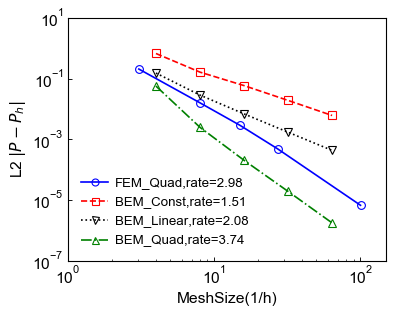

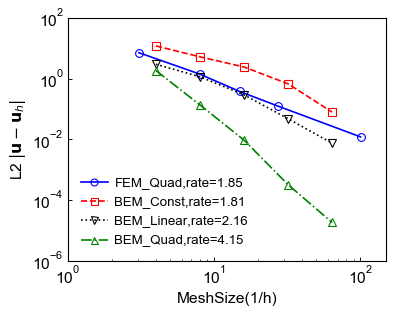

In [144]:
from utils import *

DataSetName=['FEM_Quad,rate=2.98','BEM_Const,rate=1.51','BEM_Linear,rate=2.08','BEM_Quad,rate=3.74',]
MeshSize=[1/h_FEM,1/h_BEM,1/h_BEM,1/h_BEM]
P_L2=[P2_Err_FEM,P0_Err_BEM,P1_Err_BEM,P2_Err_BEM]

print("-----------------L2 error-----------------")
plotTables(X=MeshSize,Y=P_L2, DataNames=DataSetName,
           XLable='MeshSize(1/h)',YLabel='L2 $|P-P_h|$',Xlim=[1,150],Ylim=[1e-7,10],
           img_fname='L2_Pressure.pdf',logXY=True)

DataSetName=['FEM_Quad,rate=1.85','BEM_Const,rate=1.81','BEM_Linear,rate=2.16','BEM_Quad,rate=4.15',]
U_L2=[U2_Err_FEM,U0_Err_BEM,U1_Err_BEM,U2_Err_BEM]
plotTables(X=MeshSize,Y=U_L2, DataNames=DataSetName,
           XLable='MeshSize(1/h)',YLabel='L2 $|\mathbf{u}-\mathbf{u}_h|$',Xlim=[1,150],Ylim=[1e-6,100],
           img_fname='L2_Velocity.pdf',logXY=True)

In [ ]:
xx=BEM_Case1.PostProcess.plot_Solution(exact_sol=ExactSol,resolution=40,SubPlots=['P'],img_fname='Exact_Field.pdf')

In [68]:
BEM_Case1.get_Solution((0.5,0.5))

(2.3612560470626773, 1.606845114816967, -2.2124777561620728)

In [61]:
ExactSol((0.5,0.5))

(0.008916351156184834, -2.7443397462536263e-17, -0.11204695464584487)

In [13]:
np.array(Field_Solve(0.01,0.98,BEM_Case1.BEs_edge,BEM_Case1.Mesh))

array([  5.25882827,   7.14273421, -48.19296718])

## Solution Verification

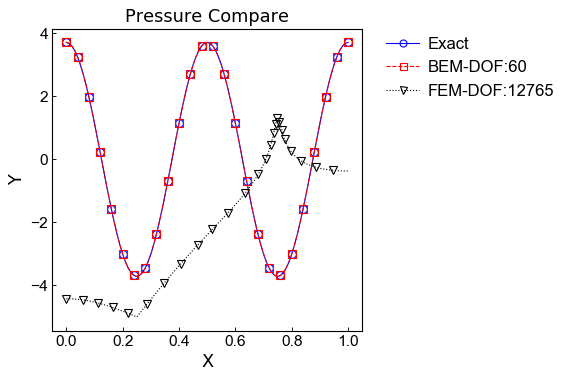

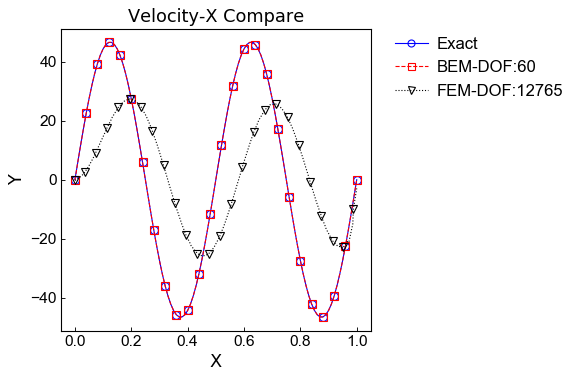

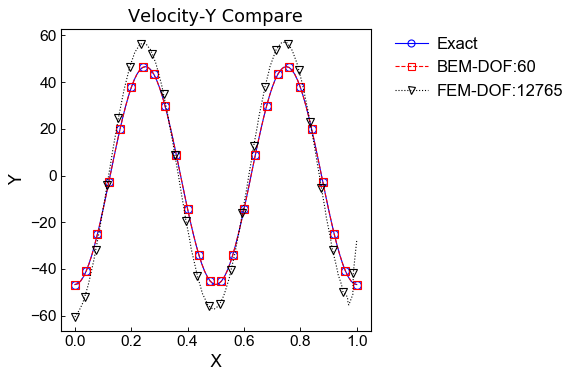

In [11]:
Pts1,Pts2=(0.0,0.98),(1.0,0.98)

#Exact Solution
PUV_exact=BEM_Case1.PostProcess.plot_Solution_overline(Pts1,Pts2,func=ExactSol,plot=False)
#BEM Solution
PUV=BEM_Case1.PostProcess.plot_Solution_overline(Pts1,Pts2,plot=False)
#Get Comsol Data
P = np.genfromtxt('.\Verification\SquareDomain2_p.csv', comments='%',delimiter=',')
U = np.genfromtxt('.\Verification\SquareDomain2_u.csv', comments='%',delimiter=',')
V = np.genfromtxt('.\Verification\SquareDomain2_v.csv', comments='%',delimiter=',')

#Compare Pressure
DataNames=['Exact','BEM-DOF:60','FEM-DOF:12765']
DataSetX=[PUV_exact[:,0],PUV[:,0],P[:,0]]

DataSetY=[PUV_exact[:,1],PUV[:,1],P[:,1]]
BEM_Case1.PostProcess.Compare_LinePlots(DataSetX,DataSetY,DataNames,'Pressure Compare')

DataSetX=[PUV_exact[:,0],PUV[:,0],U[:,0]]
DataSetY=[PUV_exact[:,2],PUV[:,2],U[:,1]]
BEM_Case1.PostProcess.Compare_LinePlots(DataSetX,DataSetY,DataNames,'Velocity-X Compare')

DataSetX=[PUV_exact[:,0],PUV[:,0],V[:,0]]
DataSetY=[PUV_exact[:,3],PUV[:,3],V[:,1]]
BEM_Case1.PostProcess.Compare_LinePlots(DataSetX,DataSetY,DataNames,'Velocity-Y Compare')